In [1]:
import os
import pickle
import numpy as np
import pandas as pd

from skimage import io
from skimage import color
from skimage import transform

import matplotlib.pyplot as plt

import datetime

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from IPython.display import Image
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

import tensorflow_addons as tfa

In [4]:
images = np.empty(shape = 810, dtype = object)
masks = np.empty(shape = 810, dtype = object)

data_path = "CVPPP2017_LCC_training/training"

folders = os.listdir(data_path)

index = 0

for folder in folders:
    cur_path = data_path + "/" + folder
    files = os.listdir(cur_path)
    files.sort()
    i = 1   #This would be a segementation mask file, after this will be a rgb image
    #Ignore the first File, it will be a csv file
    while i < len(files):
        mask_path = cur_path + "/" + files[i]
        image_path = cur_path + "/" + files[i+1]
        #segmentation mask
        masks[index] = mask_path
        
        #image path of the respective mask
        images[index] = image_path
        
        #update i and index
        i+=2
        index+=1

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, shuffle=True, test_size=0.20)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

## Load Image from paths and Data Augmentation

In [7]:
# Load Image
@tf.function
def get_images_and_masks(image_path, mask_path):
    image = tf.io.decode_png(tf.io.read_file(image_path), channels = 3)
    mask = tf.io.decode_png(tf.io.read_file(mask_path), channels = 1)
    image = tf.image.convert_image_dtype(image, tf.float64)
    mask = tf.image.convert_image_dtype(mask, tf.float64)
    #Resizing
    image = tf.image.resize(image, [224, 224])
    mask = tf.image.resize(mask, [224, 224])
    return image, mask

In [8]:
#Data Augmentation
@tf.function
def data_augmentation(image, mask):
    random_number = tf.random.uniform(shape = [], maxval = 5, dtype = tf.int32)
    
    #Apply rotation
    if tf.equal(random_number, tf.constant(1)):
        image, mask = rotate_image(image, mask)
        
    #Apply horizontal flip
    elif tf.equal(random_number, tf.constant(1)):
        image, mask = random_horizontal_flip(image, mask)
    
    #Apply vertical flip
    elif tf.equal(random_number, tf.constant(1)):
        image, mask = random_vertical_flip(image, mask)
    
    #Apply Gaussian Blur
    elif tf.equal(random_number, tf.constant(1)):
        image, mask = gaussian_blur(image, mask)
        
    #no augmentation
    else:
        pass
    
    return image, mask

In [9]:
#Augmentation Helpers
@tf.function
def gaussian_blur(image, mask):
    image = tfa.image.gaussian_filter2d(image, filter_shape=100, sigma=16.6, padding="SYMMETRIC")
    return image, mask

@tf.function
def random_horizontal_flip(image, mask):
    random_num = tf.random.uniform([], 0, 1.0)
    cond_value = tf.less(random_num, 0.5)
    image = tf.cond(cond_value, lambda: tf.image.flip_left_right(image), lambda: image)
    mask = tf.cond(cond_value, lambda: tf.image.flip_left_right(mask), lambda: mask)
    return image, mask

@tf.function
def random_vertical_flip(image, mask):
    random_num = tf.random.uniform([], 0, 1.0)
    cond_value = tf.less(random_num, 0.5)
    image = tf.cond(cond_value, lambda: tf.image.flip_up_down(image), lambda: image)
    mask = tf.cond(cond_value, lambda: tf.image.flip_up_down(mask), lambda: mask)
    return image, mask

@tf.function
def rotate_image(image, mask):
    image = tfa.image.rotate(image, 4, interpolation="NEAREST")
    mask = tfa.image.rotate(mask, 4, interpolation="NEAREST")
    return image, mask

In [10]:
train_dataset = train_dataset.map(get_images_and_masks).map(data_augmentation)
val_dataset = val_dataset.map(get_images_and_masks)
test_dataset = test_dataset.map(get_images_and_masks)

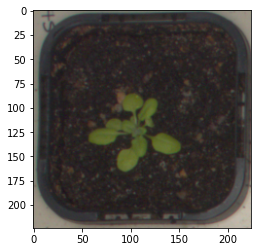

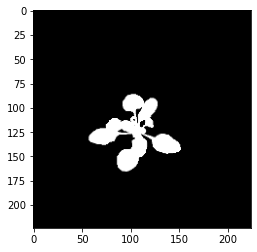

--------------------------------------------------


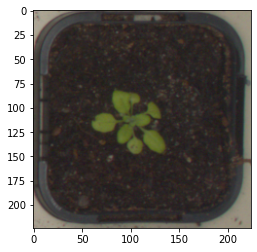

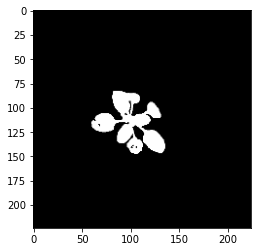

--------------------------------------------------


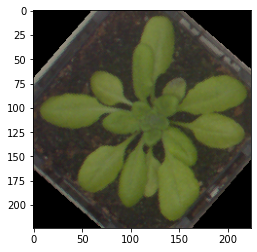

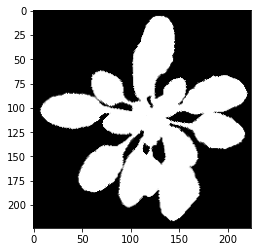

--------------------------------------------------


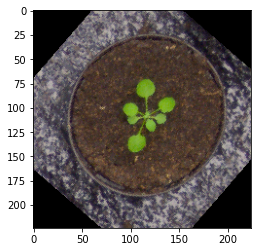

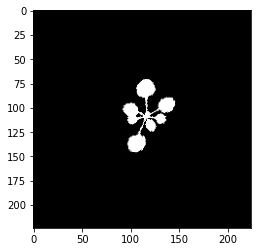

--------------------------------------------------


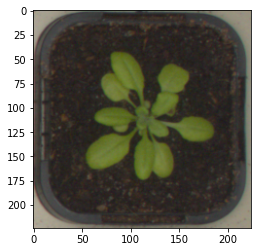

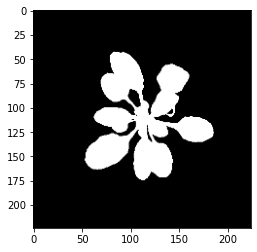

--------------------------------------------------


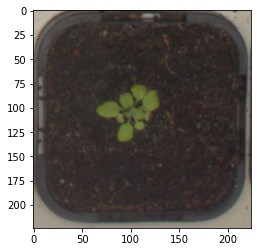

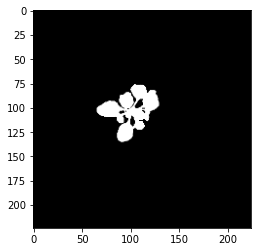

--------------------------------------------------


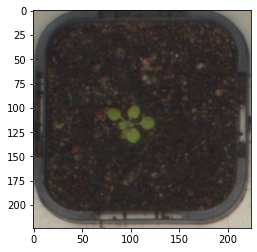

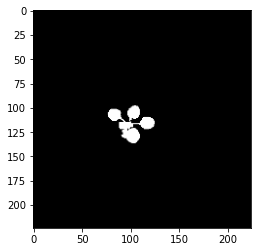

--------------------------------------------------


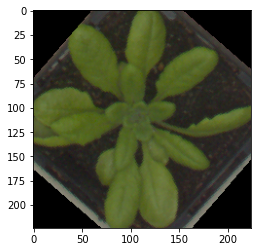

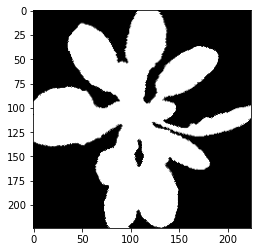

--------------------------------------------------


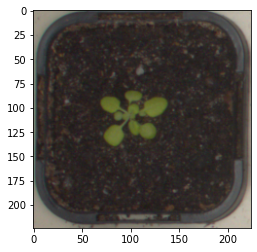

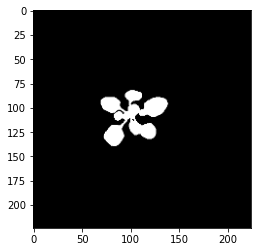

--------------------------------------------------


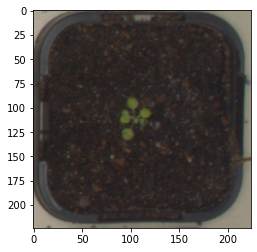

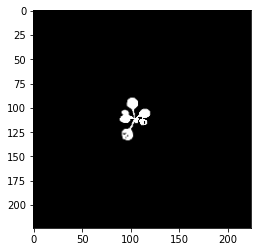

--------------------------------------------------


In [11]:
# Checking
for image, mask in train_dataset.take(10):
    plt.imshow(image.numpy())
    plt.show()
    plt.imshow(np.reshape(mask.numpy(), (224, 224)), cmap = 'gray')
    plt.show()
    print("-"*50)

## Hyperparameters, Repeat and Batching

In [12]:
BATCH_SIZE = 64
BUFFER_SIZE = 150
repeat_count = None

In [13]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).repeat(repeat_count).batch(BATCH_SIZE).prefetch(5)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).repeat(repeat_count).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)

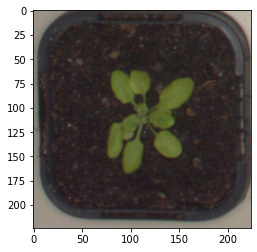

(224, 224, 3)
RED
Max value: 0.77067924
Min value: 0.07626762
Green
Max value: 0.7303596
Min value: 0.030007277
Blue
Max value: 0.6716098
Min value: 0.020723231
--------------------------------------------------


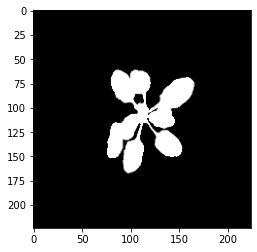

Max:  1.0
Min: 0.0


In [14]:
#Checking if all pixel values are between 0 and 1

for image, mask in train_dataset.take(1):
    plt.imshow(image[0].numpy())
    plt.show()
    print(image[0].shape)
    print("RED")
    print("Max value:", np.max(image[0, :, :, 0].numpy()))
    print("Min value:", np.min(image[0, :, :, 0].numpy()))
    print("Green")
    print("Max value:", np.max(image[0, :, :, 1].numpy()))
    print("Min value:", np.min(image[0, :, :, 1].numpy()))
    print("Blue")
    print("Max value:", np.max(image[0, :, :, 2].numpy()))
    print("Min value:", np.min(image[0, :, :, 2].numpy()))
    print("-"*50)
    plt.imshow(np.reshape(mask[0].numpy(),(224,224)), cmap = "gray")
    plt.show()
    print("Max: ", np.max(np.reshape(mask[0].numpy(),(224,224))))
    print("Min:", np.min(np.reshape(mask[0].numpy(),(224,224))))

## Segemntation Model

In [15]:
# Making Custom layers for Maxpooling and Unpooling with indices

class MaxPoolingWithArgmax2D(layers.Layer):
    def __init__(self, pool_size=(2,2), strides=(2,2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.strides = strides
        self.pool_size = pool_size
        
    #DEfine the layer logic in call function
    def call(self, inputs):
        padding = self.padding
        strides = self.strides
        pool_size = self.pool_size
        
        if(K.backend() == "tensorflow"):
            # Using tf.nn.max_pool_with_argmax for maxpooling operation
            # Adding 1 at end and start 
            # since we need to specify window size for each dimension (i.e batch, height, width, channel)
            ksize = [1, pool_size[0], pool_size[1], 1]
            # same for strides as well
            strides = [1, strides[0], strides[1], 1]
            padding = padding.upper()
            
            output, argmax = tf.nn.max_pool_with_argmax(
                inputs,
                ksize = ksize,
                strides=strides,
                padding=padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
            
        return [output, argmax]
    
def unpool(pool, indices, pool_size=(2,2), scope='unpool'):
    with tf.compat.v1.variable_scope(scope):
        input_shape = tf.shape(pool)
        output_shape = [input_shape[0], input_shape[1]*pool_size[0], input_shape[2]*pool_size[1], input_shape[3]]

        # Flatten the pool and output based on their corresponding shapes
        flat_input_size = tf.reduce_prod(input_shape)
        flat_output_shape = [output_shape[0], output_shape[1]*output_shape[2]*output_shape[3]]

        pool_values = tf.reshape(pool, [flat_input_size])
        batch_range = tf.reshape(tf.range(tf.cast(output_shape[0], tf.int64), dtype = indices.dtype), shape = [input_shape[0], 1, 1, 1])

        # Create indices from flattened array i.e. unravelling the indices from maxpooling
        b = tf.ones_like(indices) * batch_range
        b1 = tf.reshape(b, [flat_input_size, 1])
        indices_ = tf.reshape(indices, [flat_input_size, 1])
        indices_ = tf.concat([b1, indices_], 1)

        # Fill the tensor with specific indices returned from corresponding maxpool layer with the pool(output) values
        return_tensor = tf.scatter_nd(indices_, pool_values, shape = tf.cast(flat_output_shape, tf.int64))
        # Reshape to fit the return output shape
        return_tensor = tf.reshape(return_tensor, output_shape)

        set_input_shape = pool.get_shape()
        set_output_shape = [set_input_shape[0], set_input_shape[1]*pool_size[0], set_input_shape[2]*pool_size[1], set_input_shape[3]]
        return_tensor.set_shape(set_output_shape)
        return return_tensor

class MaxUnpooling2D(layers.Layer):
    def __init__(self, pool_size=(2,2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.pool_size = pool_size
        
    def call(self, inputs, output_shape = None):
        pool = inputs[0] # This is the output from previous layer
        indices = tf.cast(inputs[1], dtype = tf.int64) # indices from the corresponding pooling layer
        return unpool(pool, indices, self.pool_size)

In [16]:
def Conv_BN_relu(input_tensor, filters):
    conv = layers.Convolution2D(filters, (3,3), padding="same")(input_tensor)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation("relu")(conv)
    return conv

In [17]:
input = layers.Input(shape=(224, 224, 3))

# Convolutions -- Encoder parts
conv1 = Conv_BN_relu(input, 32)
conv2 = Conv_BN_relu(conv1, 32)
pool_1, argmax_1 = MaxPoolingWithArgmax2D(pool_size=(2,2))(conv2) # Shape = (112, 112, 32)

conv3 = Conv_BN_relu(pool_1, 64)
conv4 = Conv_BN_relu(conv3, 64)
pool_2, argmax_2 = MaxPoolingWithArgmax2D(pool_size=(2,2))(conv4) # Shape = (56, 56, 64)


conv5 = Conv_BN_relu(pool_2, 128)
conv6 = Conv_BN_relu(conv5, 128)
conv7 = Conv_BN_relu(conv6, 128)
pool_3, argmax_3 = MaxPoolingWithArgmax2D(pool_size=(2,2))(conv7) # Shape(28, 28, 128)

conv8 = Conv_BN_relu(pool_3, 256)
conv9 = Conv_BN_relu(conv8, 256)
conv10 = Conv_BN_relu(conv9, 256)
pool_4, argmax_4 = MaxPoolingWithArgmax2D(pool_size=(2,2))(conv10) # Shape(14, 14, 256)

conv11 = Conv_BN_relu(pool_4, 512)
conv12 = Conv_BN_relu(conv11, 512)
conv13 = Conv_BN_relu(conv12, 512)
pool_5, argmax_5 = MaxPoolingWithArgmax2D(pool_size=(2,2))(conv13)

# Deconvulations -- Decoder part
unpool_1 = MaxUnpooling2D(pool_size=(2,2))([pool_5, argmax_5])
conv14 = Conv_BN_relu(unpool_1, 512)
conv15 = Conv_BN_relu(conv14, 512)
conv16 = Conv_BN_relu(conv15, 256)

unpool_2 = MaxUnpooling2D(pool_size=(2,2))([conv16, argmax_4])
conv17 = Conv_BN_relu(unpool_2, 256)
conv18 = Conv_BN_relu(conv17, 256)
conv19 = Conv_BN_relu(conv18, 128)

unpool_3 = MaxUnpooling2D(pool_size=(2,2))([conv19, argmax_3])
conv20 = Conv_BN_relu(unpool_3, 128)
conv21 = Conv_BN_relu(conv20, 128)
conv22 = Conv_BN_relu(conv21, 64)

unpool_4 = MaxUnpooling2D(pool_size=(2,2))([conv22, argmax_2])
conv23 = Conv_BN_relu(unpool_4, 64)
conv24 = Conv_BN_relu(conv23, 32)

unpool_5 = MaxUnpooling2D(pool_size=(2,2))([conv24, argmax_1])
conv25 = Conv_BN_relu(unpool_5, 32)


output = layers.Convolution2D(1, (1,1), padding="same", activation="sigmoid")(conv25)

segnet_model = Model(inputs = [input], outputs = [output])
segnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Training

In [18]:
# Define Loss Function
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [19]:
# Setting up tensorboard

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [20]:
# Load the tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 3854), started 0:00:55 ago. (Use '!kill 3854' to kill it.)

In [ ]:
# Compile and train
tf.keras.backend.clear_session()
segnet_model.compile(
    loss=bce,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics=["accuracy"]
)

EPOCHS = 5

fit_history = segnet_model.fit(
    train_dataset,
    epochs = EPOCHS,
    verbose = 1,
    callbacks = [tensorboard_callback],
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val)//BATCH_SIZE
)

Epoch 1/5


In [ ]:
train_dataset